## Bergfex Webscraping
<b> Milestone 1</b> 

Scraping the Bergfex.com website in order to create Pandas dataframes that contain important information about each trail. This code uses BeautifulSoup to parse the html tags into json, which is easier to work with. A for-loop iterates over each html tag and adds the corresponding information into empty lists. Data is cleaned and an initial data analysis is performed.

Finally, also the corresponding GPS data is downloaded and scraped.
The functions created in this notebook allow to easily repeat the steps or perform them for different regions.

### Imports

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup 
import requests
import re
import math

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.image as mpimg
import seaborn as sns

import datetime as dt
import time
import glob
import gpxpy 
import gpxpy.gpx

# 1  Data scraping

Prepare to scrape the Bergfex.com website in order to create a Pandas dataframe that contain important information about each trail. This code uses BeautifulSoup to parse the html tags into json. A for-loop iterates over each html tag and adds the corresponding information into empty lists. 

## 1.1 Scrape all the information (basic and embedded)

In [2]:
# Creating empty lists to store the scraped data

title = []  # title of the tour
difficulty = []  # difficulty (easy, medium, hard)
sport = []  # sport type (hiking, sledging, snowshoe...)
length = []  # length in km
time_list = []  # tour time in hours:minutes
climb = []  # positive elevation climb in m
minmax = []  # minimum and maximum altitude of the tour in m
technique = []  # technique difficulty ratings (out of 6)
fitness = []  # fitness difficulty ratings (out of 6)
total_title = [] # will help extracting the ID of the tour

# the storing of rating is a bit different so we will need this along the way:
rating = []  # technique and fitness rating info

In [3]:
# looping over the X first pages of Bergfex, here 2
# each separate tour on the page is framed by a div tag with 'touren-details'

page_number = 2  # number of pages we want to scrape through (keep low for demo purposes)

for p in range(1, (page_number+1)):
    base_link = 'https://www.bergfex.com/sommer/bern-region/touren/?isAjax=1&page='
    link = base_link+str(p)  # going over p pages with numbers appended to the base link
    page = requests.get(link, timeout=5)
    print("scraped page", p)
    soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
    tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

# For each page, we loop over each tour and fill our lists with info     
    for i in range(0,len(tours)):
        tour_1 = tours[i] # tour iterating over the 20 tours of the page

        tour_title = tour_1.findAll('a' ) # this gets the title out
        title.append([info.get_text().strip() for info in tour_title])
        total_title.append(tour_title) 
        # this gets the full tour-title information including the ID 
        # will need to be processed further later on
        
        tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) # tour level difficulty
        difficulty.append([info.get_text().strip() for info in tour_diff])

        tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
        sport.append([info.get_text().strip() for info in tour_type])

        tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
        stat_text = [info.get_text().strip() for info in tour_stats]
        length.append(stat_text[0])
        time_list.append(stat_text[1])
        climb.append(stat_text[2])
        minmax.append(stat_text[3])
        
        tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
        rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.

scraped page 1
scraped page 2


In [4]:
soup

<!DOCTYPE html>

<html>
<head>
<title>BERGFEX-  Swiss plateau - Hiking &amp; Mountain biking</title>
<script src="https://cdn.stroeerdigitalgroup.de/metatag/live/SDG_ConsentOnly/metaTag.min.js" type="text/javascript"></script>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="en" http-equiv="Content-Language"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<meta content="en" name="language"/>
<meta content="width=device-width, viewport-fit=cover" name="viewport"/>
<script type="application/ld+json">
{
"@context": "https://schema.org",
"@type": "Organization",
"url": "https://www.bergfex.com",
"logo": "https://www.bergfex.com/images/logo.png"
}
</script>
<meta content="" property="og:title"/>
<meta content="https://vcdn.bergfex.at/images/resized/d8/a65a94fd11f0d3d8_2931d3a04a0e346a.jpg" property="og:image"/>
<meta content="image/jpg" property="og:image:type"/>
<meta content="1200" property="og:image:width"/>
<meta content="627" property="og:ima

In [5]:
tours  # all raw 'touren-details' we scraped

[<div class="touren-detail">
 <a class="h2" href="/sommer/bern-region/touren/mountainbike/133928,blueme-III/" title="Blueme III">Blueme III</a>
 <div>
 <span class="tour-difficulty tour-difficulty-2">
 medium
 </span>
 <span class="tour-type">
 Mountainbike
 </span>
 </div>
 <div class="tour-stats-photos-container">
 <div class="tour-stats-container">
 <div class="tour-stats-left">
 <div class="tour-stats tour-stats-big">
 <div class="tour-stats-icon tour-stats-icon-length"></div>
 26.93<span class="tour-stats-unit">km</span>
 </div>
 <div class="tour-stats">
 <div class="tour-stats-icon tour-stats-icon-time"></div>
 <strong>03:00</strong><span class="tour-stats-unit">h</span>
 </div>
 </div>
 <div class="tour-stats-right">
 <div class="tour-stats tour-stats-big">
 <div class="tour-stats-icon tour-stats-icon-up"></div>
 1,320<span class="tour-stats-unit">hm</span>
 </div>
 <div class="tour-stats">
 <div class="tour-stats-icon tour-stats-icon-updown"></div>
 566 - 1,392<span class="tour

In [6]:
print("number of tours collected:", len(title))

number of tours collected: 40


## 1.2 Extracting embedded HTML tags: <a href="" 
Each trail name and ID was used in Bergfex's URL. Using the trail ID in the dataframe will provide a unique ID to use later in the analysis. However, those two data points are embedded deeper in the html code. The below codes shows how to extract the datapoints into a dataframe.

In [7]:
# Extracting the ID via the URL
links_title = []

for i in total_title:
    i = str(i)
    i = i.strip('[]')
    links_title.append(i)

In order to make the trail ID usable it needs to be cleaned up and converted into a string

In [8]:
# Extracting ID
id_df3 = pd.DataFrame(links_title)
id_df2 = id_df3[0].str.split(' ',expand = True)
id_df1 = id_df2[2].str.split(',',expand = True)
id_df = id_df1[0].str.split('/',expand = True)

In [9]:
# from this format:
pd.options.display.max_colwidth = 100
id_df3.head()

,0
0,"<a class=""h2"" href=""/sommer/bern-region/touren/themenweg/295442,diemtigtaler-hausweg-vorderes-ta..."
1,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/891220,gfw-15--rund-ume-frienisberger/""..."
2,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/114260,elsigenalp--zu-einem-stillen-ber..."
3,"<a class=""h2"" href=""/sommer/bern-region/touren/radfahren/700218,matten--gfell--st-stephan--matte..."
4,"<a class=""h2"" href=""/sommer/bern-region/touren/wanderung/354688,horneggli--hornberg--horneggli-b..."


In [10]:
# to this format:
id_df.head()

,0,1,2,3,4,5
0,"href=""",sommer,bern-region,touren,themenweg,295442
1,"href=""",sommer,bern-region,touren,wanderung,891220
2,"href=""",sommer,bern-region,touren,wanderung,114260
3,"href=""",sommer,bern-region,touren,radfahren,700218
4,"href=""",sommer,bern-region,touren,wanderung,354688


## 1.3 Extracting embedded HTML tags: <Div class=""
The HTML tags for the fitness and technique ratings were embedded within Div class tags; they are extracted using a for-loop and then stripped of unnecessary characters. 
- Convert the tour rating tag into a string
- Strip away unnecessary characters 
- Split into lists which look like rating_list [Technique, Fitness]
- Finally, convert into separate lists for Technique and Fitness

In [11]:
rating[0] # View the emmbedded DIV tag

[<div class="tour-rating">
 <div class="tour-rating-label">Technique</div>
 <div class="rating-circles rating-max6"><div class="rating-1"></div></div>
 </div>,
 <div class="tour-rating">
 <div class="tour-rating-label">Fitness</div>
 <div class="rating-circles rating-max6"><div class="rating-2"></div></div>
 </div>]

In [12]:
# Replace unwanted information
tour_rating_str = str(rating)
rating_all_short = tour_rating_str.replace(
'<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
).replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="',''
).replace('"></div></div>\n</div>',"")
rating_even_shorter = rating_all_short.replace('[','').replace(']','')
rating_list = rating_even_shorter.split(", ")

for i in range(0,(len(rating_list))):
    if i == 0:
        technique.append(rating_list[i]) # add first item in technique
    elif i % 2 == 0:
        technique.append(rating_list[i]) # then every second item as well
    else:
        fitness.append(rating_list[i]) # the other appended to fitness list

In [13]:
## Let's look at the result

#rating_all_short
#rating_even_shorter
rating_list

['rating-1',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-3',
 'rating-1',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-3',
 'rating-1',
 'rating-1',
 'rating-',
 'rating-4',
 'rating-1',
 'rating-5',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-4',
 'rating-2',
 'rating-4',
 'rating-1',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-3',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-1',
 'rating-2',
 'rating-4',
 'rating-6',
 'rating-1',
 'rating-2',
 'rating-2',
 'rating-4',
 'rating-2',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-3',
 'rating-2',
 'rating-1',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-2',
 'rating-3',
 'rating-2',
 'rating-2',
 'rating-',
 'rating-0',
 'rating-1',
 'rating-2',
 'rating-2',
 'rating-3',
 'rating-3',
 'ra

## 1.4  Create dataframe for extracted elements

This dataframe is not in the final stage yet as there are still extra brackets, the minimum and maximum elevation are still in one column, and units must be stripped away... By collecting all information in one dataframe it makes data cleaning easier.

In [14]:
activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
activities_df_unclean.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Diemtigtaler Hausweg «Vorderes Tal»],[easy],[Thematic route],8.93km,03:00h,438hm,670 - 964m,rating-1,rating-2,295442
1,[GFW 15 - Rund ume Frienisberger],[],[Hiking],14.65km,04:20h,300hm,567 - 818m,rating-,rating-0,891220
2,[Elsigenalp - Zu einem stillen Bergseelein],[medium],[Hiking],7.39km,02:50h,514hm,"1,796 - 2,299m",rating-3,rating-3,114260
3,[Matten - Gfell - St. Stephan - Matten],[easy],[Cycling],11.25km,01:20h,476hm,"994 - 1,467m",rating-1,rating-2,700218
4,[Horneggli - Hornberg - Horneggli (Blumenweg)],[easy],[Hiking],2.7km,01:00h,101hm,"1,767 - 1,868m",rating-2,rating-2,354688


## 1.5 Write CSV file of scrapped and uncleaned DF
This is just an intermediate step to be able to look at the data before the cleaning. Strictly speaking it is not really necessary.

In [15]:
activities_df_unclean.to_csv("../data/unclean_activities.csv", index=False)
activities_df_unclean.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,[Diemtigtaler Hausweg «Vorderes Tal»],[easy],[Thematic route],8.93km,03:00h,438hm,670 - 964m,rating-1,rating-2,295442
1,[GFW 15 - Rund ume Frienisberger],[],[Hiking],14.65km,04:20h,300hm,567 - 818m,rating-,rating-0,891220
2,[Elsigenalp - Zu einem stillen Bergseelein],[medium],[Hiking],7.39km,02:50h,514hm,"1,796 - 2,299m",rating-3,rating-3,114260
3,[Matten - Gfell - St. Stephan - Matten],[easy],[Cycling],11.25km,01:20h,476hm,"994 - 1,467m",rating-1,rating-2,700218
4,[Horneggli - Hornberg - Horneggli (Blumenweg)],[easy],[Hiking],2.7km,01:00h,101hm,"1,767 - 1,868m",rating-2,rating-2,354688


##  1.6 Combine all steps in a scraping function

To be able to repeat the same steps for a different region (for example "Wallis"), we put the scraping code into a function. Here we can choose the region, how many pages we want to scrape and whether we want to save the file as CSV.

In [16]:
def scraping_region(region, n_pages):
    """
    This function scrapes the webpage for X number of pages and for a specific region.

    Required arguments:
    - region: string, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'
    - n_pages: int, determines how many pages will be scraped.

    Returns:
    - lists containing information on title, difficulty, sport, length, time_list, 
    climb, minmax, total_title, rating: strings.
    """
    
    title = []  # Title of the tour
    difficulty = []  # difficulty (easy, medium, hard)
    sport = []  # Sport type (hiking, sledging, snowshoe...)
    length = []  # length in km
    time_list = []  # tour time in hours:minutes
    climb = []  # positive elevation climb in m
    minmax = []  # minimum and maximum altitude of the tour in m
    total_title = [] # will help extracting the ID of the tour
    # all ratings are stored together so we will need this along the way:
    rating = []  # list to store technique and fitness rating info
    
    # looping over the x first pages of Bergfex
    # each separate tour on the page is framed by a div tag with 'touren-details'
    page_number = n_pages  # number of pages we want to scap through

    for p in range(1, (page_number+1)):
        base_link = f'https://www.bergfex.com/sommer/{region}/touren/?isAjax=1&page='
        link = base_link+str(p)  # going over p pages with numbers appended to the base link
        page = requests.get(link, timeout=5)
        print("scraped page", p)
        soup = BeautifulSoup(page.content, "html.parser")  # bs4.BeautifulSoup object
        tours = soup.findAll('div', {'class': 'touren-detail'})  # checks for the separate tours on the page

    # For each page, we loop over each tour and fill our lists with info     
        for i in range(0,len(tours)):
            tour_1 = tours[i] # tour iterating over the 20 tours of the page

            tour_title = tour_1.findAll('a' ) # this gets the title out
            title.append([info.get_text().strip() for info in tour_title])
            total_title.append(tour_title) 
            # this gets the full tour-title information including the ID, processed further later on

            tour_diff = tour_1.findAll('span', {'class': 'tour-difficulty'}) #tour level difficulty
            difficulty.append([info.get_text().strip() for info in tour_diff])

            tour_type = tour_1.findAll('span', {'class': 'tour-type'}) # putting type into sports
            sport.append([info.get_text().strip() for info in tour_type])

            tour_stats = tour_1.findAll('div', {'class': 'tour-stats'}) # stats has 4 info binned together
            stat_text = [info.get_text().strip() for info in tour_stats]
            length.append(stat_text[0])
            time_list.append(stat_text[1])
            climb.append(stat_text[2])
            minmax.append(stat_text[3])

            tour_rating = tour_1.find_all("div", {'class': 'tour-rating'}) # getting the rating data 
            rating.append([info for info in tour_rating])   # it's a class name so we can't get_text.
    print("number of tours collected:", len(title))
    return (title, difficulty, sport, length, time_list, climb, minmax, total_title, rating)

In [17]:
def extracting_id(total_title):
    """
    This function extracts the ID from the total_title.

    Required arguments:
    - total_title: list of strings, extracted in the previous step (scraping_region function).

    Returns:
    - id_df: dataframe with string fragments of the total_title.
    """
    
    links_title = []
    for i in total_title:
        i = str(i)
        i = i.strip('[]')
        links_title.append(i)
    # Extracting ID
    id_df3 = pd.DataFrame(links_title)
    id_df2 = id_df3[0].str.split(' ',expand = True)
    id_df1 = id_df2[2].str.split(',',expand = True)
    id_df = id_df1[0].str.split('/',expand = True)
    
    return id_df

In [18]:
def extracting_rating(rating):
    """
    This function extracts the ratings for Technique and Fitness from the rating.

    Required arguments:
    - rating: list of strings, extracted in the previous step (scraping_region function).

    Returns:
    - technique: list with strings.
    - fitness: list with strings.
    """
    
    technique = []  # technique difficulty ratings (out of 6)
    fitness = []  # fitness difficulty ratings (out of 6)
    # Replace unwanted information
    tour_rating_str = str(rating)
    rating_all_short = tour_rating_str.replace(
    '<div class="tour-rating">\n<div class="tour-rating-label">Technique</div>\n<div class="rating-circles rating-max6"><div class="',''
    ).replace(
        '<div class="tour-rating">\n<div class="tour-rating-label">Fitness</div>\n<div class="rating-circles rating-max6"><div class="','').replace('"></div></div>\n</div>',"")
    rating_even_shorter = rating_all_short.replace('[','').replace(']','')
    rating_list = rating_even_shorter.split(", ")

    for i in range(0,(len(rating_list))):
        if i == 0:
            technique.append(rating_list[i]) # add first item in technique
        elif i % 2 == 0:
            technique.append(rating_list[i]) # then every second item as well
        else:
            fitness.append(rating_list[i]) # the other appended to fitness list
    return technique, fitness

In [19]:
def create_scraped_df(region, n_pages, save_as_csv = True):
    """
    This function executes all the previously created functions ('scraping_region', 
    'extracting_id', 'extracting_rating'), gathers all the obtained information in one dataframe
    and optionally saves it in a csv file.

    Required arguments:
    - region: string,to save the results under region specific name, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'
    - n_pages: int, determines how many pages will be scraped.
    
    Optional arguments:
    - save_as_csv: boolean, 'True' if intermediate CSV file should be created and saved.
    
    Returns:
    - activities_df_unclean: dataframe, that contains all the scraped and uncleaned information.
    """
    
    title, difficulty, sport, length, time_list, climb, minmax, total_title, rating = scraping_region(
        region, n_pages)
    id_df = extracting_id(total_title)
    technique, fitness = extracting_rating(rating)
    activities_df_unclean = pd.DataFrame(
    {'title': title,
     'difficulty': difficulty,
     'sport': sport,
     'length': length,
     'time': time_list,
     'climb': climb,
     'minmax': minmax,
     'technique': technique,
     'fitness': fitness
    })
    activities_df_unclean['ID']= id_df.iloc[:,5].copy() # add the ID columns from an earlier DF
    
    if save_as_csv == True:
        activities_df_unclean.to_csv(f"../data/unclean_activities_{region}.csv", index=False)
        
    return activities_df_unclean

Let's test it with different regions.

In [20]:
region2 = "wallis"
n_pages2 = 20
#create_scraped_df(region2, n_pages2, save_as_csv = True)
#create_scraped_df('bern-region', n_pages2, save_as_csv = True)

# 2  Data Cleaning

As mentioned above, the dataframe still needs to be cleaned up. 

## 2.1 Reading the "uncleaned" DF

In [21]:
activities_df_raw = pd.read_csv(f"../data/unclean_activities.csv")
activities_df = activities_df_raw.copy()
activities_df.head()

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,['Diemtigtaler Hausweg «Vorderes Tal»'],['easy'],['Thematic route'],8.93km,03:00h,438hm,670 - 964m,rating-1,rating-2,295442
1,['GFW 15 - Rund ume Frienisberger'],[],['Hiking'],14.65km,04:20h,300hm,567 - 818m,rating-,rating-0,891220
2,['Elsigenalp - Zu einem stillen Bergseelein'],['medium'],['Hiking'],7.39km,02:50h,514hm,"1,796 - 2,299m",rating-3,rating-3,114260
3,['Matten - Gfell - St. Stephan - Matten'],['easy'],['Cycling'],11.25km,01:20h,476hm,"994 - 1,467m",rating-1,rating-2,700218
4,['Horneggli - Hornberg - Horneggli (Blumenweg)'],['easy'],['Hiking'],2.7km,01:00h,101hm,"1,767 - 1,868m",rating-2,rating-2,354688


## 2.2 Check for duplicates and remove them
For some reasons, some trails can be duplicated. Let's identify and remove them.

In [22]:
# check if there are duplicates
dups = activities_df.duplicated(subset=['ID'])
dups

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25     True
26     True
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
dtype: bool

In [23]:
# Which trails are duplicates?
try:
    pd.concat(g for _, g in activities_df.groupby('ID') if len(g) > 1)
except ValueError:
    print('no duplicates')

In [24]:
# Remove duplicates
activities_df.drop_duplicates(subset ="ID", inplace = True)
activities_df

,title,difficulty,sport,length,time,climb,minmax,technique,fitness,ID
0,['Diemtigtaler Hausweg «Vorderes Tal»'],['easy'],['Thematic route'],8.93km,03:00h,438hm,670 - 964m,rating-1,rating-2,295442
1,['GFW 15 - Rund ume Frienisberger'],[],['Hiking'],14.65km,04:20h,300hm,567 - 818m,rating-,rating-0,891220
2,['Elsigenalp - Zu einem stillen Bergseelein'],['medium'],['Hiking'],7.39km,02:50h,514hm,"1,796 - 2,299m",rating-3,rating-3,114260
3,['Matten - Gfell - St. Stephan - Matten'],['easy'],['Cycling'],11.25km,01:20h,476hm,"994 - 1,467m",rating-1,rating-2,700218
4,['Horneggli - Hornberg - Horneggli (Blumenweg)'],['easy'],['Hiking'],2.7km,01:00h,101hm,"1,767 - 1,868m",rating-2,rating-2,354688
5,['Stockentaler Hausweg - Blumenstein'],['medium'],['Thematic route'],13.02km,03:30h,200hm,656 - 782m,rating-2,rating-3,99380
6,['Prachtswälder am Fusse des Gantrisch'],['easy'],['Hiking'],8.65km,02:40h,390hm,"783 - 1,084m",rating-2,rating-2,48767
7,['Von SAC Grubenberghütte via Pertet à Bovets nach Rougemont'],['medium'],['Hiking'],15.2km,05:00h,630hm,"1,000 - 1,908m",rating-3,rating-3,616567
8,['Biel/Bienne - Ins'],['easy'],['Long distance cycling'],31.43km,02:09h,29hm,430 - 460m,rating-1,rating-1,177067
9,['Gasterntal Biketour'],['medium'],['Mountainbike'],23.75km,03:20h,460hm,"1,170 - 1,630m",rating-,rating-4,698704


## 2.3 Clean Categorical Data
- Convert columns to strings
- Remove brackets from the first 3 columnns
- Remove extra whitespace
- Remove units
- Split the min and max altitude and put them into different columns
- Organize the dataframe columns
- Remove remaining commas
- Set an order to the difficulty level (i.e. '1 - easy' instead of 'easy')

In [25]:
# Converting the text columns to strings for easier handling later
activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty', 'sport']].astype('str')

# Removing the brackets
activities_df['title'] = activities_df['title'].str.strip('[]')
activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
activities_df['sport'] = activities_df['sport'].str.strip('[]')

# Remove extra whitespace
activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

# Remove units (km, m, h, hm, m)
activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

# Separate the minmax altitude into a min column and a max column
activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
activities_df = activities_df.drop(columns=['minmax'])

# Organize the dataframe columns
activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                               'time', 'climb', 'min', 'max', 'technique', 'fitness']]

# Remove remaining commas to avoid issues with reading CSV file in Tableau (needed in project II)
activities_df['title'] = pd.Series(activities_df['title']).str.replace(",", '-')

# Add ordering of the difficulty
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("easy", '1 - easy')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("medium", '2 - medium')
activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("difficult", '3 - difficult')
activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)

In [26]:
activities_df.head(5)

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,295442,Diemtigtaler Hausweg «Vorderes Tal»,1 - easy,Thematic route,8.93,03:00,438,670,964,rating-1,rating-2
1,891220,GFW 15 - Rund ume Frienisberger,0 - no rating,Hiking,14.65,04:20,300,567,818,rating-,rating-0
2,114260,Elsigenalp - Zu einem stillen Bergseelein,2 - medium,Hiking,7.39,02:50,514,"1,796","2,299",rating-3,rating-3
3,700218,Matten - Gfell - St. Stephan - Matten,1 - easy,Cycling,11.25,01:20,476,994,"1,467",rating-1,rating-2
4,354688,Horneggli - Hornberg - Horneggli (Blumenweg),1 - easy,Hiking,2.7,01:00,101,"1,767","1,868",rating-2,rating-2


## 2.4 Clean Numerical Data

In order to normalize numerical data for analysis, we must preform the following steps:

-  Replace missing numerical data with 0, via np.nan
-  Remove commas
-  Remove "-"
-  Remove unnecessary words ("rating-")
-  Convert into the right data type: float, int

In [27]:
activities_df['length'] = pd.Series(activities_df['length']).str.replace("-",'0')
activities_df['length'] = (activities_df['length']).astype(float)

activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
activities_df['climb'] = (activities_df['climb']).astype(int)

activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '')
activities_df['min'].replace('',np.nan, inplace = True)
activities_df['min'] = activities_df['min'].fillna(0)
activities_df['min'] = (activities_df['min']).astype(int)
activities_df['max'].replace('',np.nan, inplace = True)
activities_df['max'] = activities_df['max'].fillna(0)
activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 

activities_df['max'] = (activities_df['max']).astype(int)

activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
activities_df['fitness'] = activities_df['fitness'].astype('int')

## 2.5 Final check of DataFrame
Double check for null values. It looks pretty good!  Now it's time to start analysis. 

In [28]:
activities_df

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,295442,Diemtigtaler Hausweg «Vorderes Tal»,1 - easy,Thematic route,8.93,03:00,438,670,964,1,2
1,891220,GFW 15 - Rund ume Frienisberger,0 - no rating,Hiking,14.65,04:20,300,567,818,0,0
2,114260,Elsigenalp - Zu einem stillen Bergseelein,2 - medium,Hiking,7.39,02:50,514,1796,2299,3,3
3,700218,Matten - Gfell - St. Stephan - Matten,1 - easy,Cycling,11.25,01:20,476,994,1467,1,2
4,354688,Horneggli - Hornberg - Horneggli (Blumenweg),1 - easy,Hiking,2.70,01:00,101,1767,1868,2,2
5,99380,Stockentaler Hausweg - Blumenstein,2 - medium,Thematic route,13.02,03:30,200,656,782,2,3
6,48767,Prachtswälder am Fusse des Gantrisch,1 - easy,Hiking,8.65,02:40,390,783,1084,2,2
7,616567,Von SAC Grubenberghütte via Pertet à Bovets nach Rougemont,2 - medium,Hiking,15.20,05:00,630,1000,1908,3,3
8,177067,Biel/Bienne - Ins,1 - easy,Long distance cycling,31.43,02:09,29,430,460,1,1
9,698704,Gasterntal Biketour,2 - medium,Mountainbike,23.75,03:20,460,1170,1630,0,4


In [29]:
#activities_df.info()

###### 2.5 Write CSV

Now that the data has been cleaned properly, let's save the dataframe to a CSV for future use.

In [30]:
activities_df.to_csv("../data/activities.csv", index=False)

## 2.6 Functions for Data Cleaning

Let's again save these codes as functions to be able to run the script easily for other regions.

In [31]:
def clean_cat(activities_df):
    """
    This function cleans the categorical columns of the activities_df.

    Required arguments:
    - activities_df: dataframe, created in a previous step (create_scraped_df function)

    Returns:
    - activities_df: dataframe, cleaned by removing unnecessary signs.
    """
    
    # Converting the text columns to strings for easier handling later
    activities_df[['title', 'difficulty', 'sport']] = activities_df[['title', 'difficulty',
                                                                     'sport']].astype('str')

    # Removing the brackets
    activities_df['title'] = activities_df['title'].str.strip('[]')
    activities_df['difficulty'] = activities_df['difficulty'].str.strip('[]')
    activities_df['sport'] = activities_df['sport'].str.strip('[]')

    # Remove extra whitespace
    activities_df['title'] = pd.Series(activities_df['title']).str.replace("'", '')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace("'", '')
    activities_df['sport'] = pd.Series(activities_df['sport']).str.replace("'", '')

    # Remove units (km, m, h, hm, m)
    activities_df['length'] = pd.Series(activities_df['length']).str.replace("km", '')
    activities_df['time'] = pd.Series(activities_df['time']).str.replace("h", '')
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("hm", '')
    activities_df['minmax'] = pd.Series(activities_df['minmax']).str.replace("m", '')

    # Separate the minmax altitude into a min column and a max column
    activities_df[['min','max']] = activities_df['minmax'].str.split("-",expand=True)
    activities_df = activities_df.drop(columns=['minmax'])

    # Organize the dataframe columns
    activities_df = activities_df[['ID','title', 'difficulty', 'sport', 'length', 
                                   'time', 'climb', 'min', 'max', 'technique', 'fitness']]

    # Remove remaining commas to avoid issues with reading CSV file in Tableau (needed in project II)
    activities_df['title'] = pd.Series(activities_df['title']).str.replace(",", '-')
    
    # Add ordering of the difficulty
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace(
        "easy", '1 - easy')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace(
        "medium", '2 - medium')
    activities_df['difficulty'] = pd.Series(activities_df['difficulty']).str.replace(
        "difficult",'3 - difficult')
    activities_df['difficulty'].replace(r'^\s*$', '0 - no rating', regex=True, inplace=True)
    return activities_df

In [32]:
def clean_num(activities_df):
    """
    This function cleans the numerical columns of the activities_df.

    Required arguments:
    - activities_df: dataframe, created in a previous step (create_scraped_df function)

    Returns:
    - activities_df: dataframe, cleaned by removing unnecessary signs and converting into float/int.
    """
    
    activities_df['length'] = pd.Series(activities_df['length']).str.replace("-",'0')
    activities_df['length'] = (activities_df['length']).astype(float)

    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace(",", '') 
    activities_df['climb'] = pd.Series(activities_df['climb']).str.replace("-", '0') 
    activities_df['climb'] = (activities_df['climb']).astype(int)
    
    activities_df['min'] = pd.Series(activities_df['min']).str.replace(",", '')
    activities_df['min'].replace('',np.nan, inplace = True)
    activities_df['min'] = activities_df['min'].fillna(0)
    activities_df['min'] = (activities_df['min']).astype(int)
    activities_df['max'].replace('',np.nan, inplace = True)
    activities_df['max'] = activities_df['max'].fillna(0)
    activities_df['max'] = pd.Series(activities_df['max']).str.replace(",", '') 

    activities_df['technique'] = pd.Series(activities_df['technique']).str.replace("rating-", '')
    activities_df['technique'] = pd.to_numeric(activities_df['technique'], errors='coerce')
    activities_df['technique'] = pd.Series(activities_df['technique']).replace(np.nan, 0, regex = True)
    activities_df['technique'] = pd.Series(activities_df['technique']).astype('int')

    activities_df['fitness'] = pd.Series(activities_df['fitness']).str.replace("rating-", '')
    activities_df['fitness'] = pd.to_numeric(activities_df['fitness'], errors='coerce')
    activities_df['fitness'] = pd.Series(activities_df['fitness']).replace(np.nan, 0, regex = True)
    activities_df['fitness'] = activities_df['fitness'].astype('int')
    return activities_df

In [33]:
def clean_df(region, save_as_csv = True):
    """
    This function executes all the previously created functions ('clean_num', 'clean_cat'), 
    and optionally saves the cleaned dataframe in a csv file.

    Required arguments:
    - region: string,to save the results under region specific name, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'
    
    Optional arguments:
    - save_as_csv: boolean, 'True' if intermediate CSV file should be created and saved.
    
    Returns:
    - activities_df: dataframe, that contains cleaned information.
    """
    activities_df_unclean = pd.read_csv(f"../data/unclean_activities_{region}.csv")
    activities_df_unclean.drop_duplicates(subset ="ID", inplace = True)
    activities_df = clean_cat(activities_df_unclean)
    activities_df = clean_num(activities_df)
    #clean_time(activities_df)
    
    if save_as_csv == True:
        activities_df.to_csv(f"../data/activities_{region}.csv", index=False)
        
    return activities_df

In [34]:
def preprocess(region, n_pages, save_as_csv = True):
    """
    This function combines the previously created functions ('create_scraped_df', 'clean_df')
    to webscrape the information, puts them into a dataframe, clean the data and 
    optionally saves the dataframe in a csv file.

    Required arguments:
    - region: string,to save the results under region specific name, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'
    - n_pages: int, determines how many pages will be scraped.
    
    Optional arguments:
    - save_as_csv: boolean, 'True' if CSV file should be created and saved.
    
    Returns:
    - activities_df_unclean: dataframe, that contains all the scraped and uncleaned information.
    - activities_df: dataframe, that contains cleaned information.
    """
    if save_as_csv == True:
        save = True
    else:
        save = False
    activities_df_unclean = create_scraped_df(region, n_pages, save_as_csv = save)
    activities_df = clean_df(region, save_as_csv = save)
        
    return activities_df, activities_df_unclean

## 2.7 Create a complete database
Let's run the code for a new region or for all regions through a for-loop.
Afterwards, we hash out the code. Otherwise if you rerun the Kernel too often, there is a risk of being blocked by the website.

In [35]:
# Run code for one region (remove the hash below)
region_test1 = 'bern-region'
n_pages_test = 35
#result_test1 = preprocess(region_test1, n_pages_test, save_as_csv = True)

regions = ['aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich']

# Run code for all regions (remove the hashes below)
# for reg in regions:
 #   result_test_reg = preprocess(reg, n_pages_test, save_as_csv = True)

Let's combine all the CSV region files into one DF & CSV file:

In [36]:
all_act_df = pd.DataFrame()
for reg in regions:
    activities_df_reg = pd.read_csv(f"../data/activities_{reg}.csv")
    activities_df_reg['region'] = reg
    all_act_df = pd.concat([all_act_df, activities_df_reg], axis = 0)
    
all_act_df.to_csv(f"../data/activities_all.csv", index=False)

# 3  Initial Data Analysis

Before moving onto combining weather data with hiking trails, lets do some preliminary data analysis to see what we are working with. For that, we use the complete "bern-region" data we just scraped.

In [37]:
# Set style for the plots to follow
plt.style.use('seaborn-dark-palette')
rcParams['figure.figsize'] = 10, 8

# Read in the data
activities_df_raw_br = pd.read_csv(f"../data/activities_bern-region.csv")
activities_df_br = activities_df_raw_br.copy()
activities_df_br.head()

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,1521,1878,3,3
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,459,564,2,2
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,771,2129,1,0
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,1531,1720,2,2
4,133945,Schwander - Lebensweg,1 - easy,Thematic route,3.55,01:30,86,647,735,1,2


## 3.1 Data Exploration 

We will begin the data analysis by data exploration. By creating different data frames and removing activities with little data to improve visualizations we can get a better idea of what types of trails we are working with. 

In [38]:
# Creating a df for "Number of entries by sport type" + average tour length
sporttype = activities_df_br.groupby('sport') \
       .agg({'sport':'count', 'length':'mean'}) \
       .rename(columns={'sport':'count','length':'average_length'}) \
       .reset_index() \
       .sort_values(by=['average_length'])
sporttype

,sport,count,average_length
13,Thematic route,30,5.363333
8,Nordic Walking,2,5.905000
12,Snowshoe,1,8.120000
3,High tour,2,8.695000
4,Hiking,188,9.913830
11,Running,3,10.443333
15,Via ferrata,2,13.650000
14,Trailrunning,12,19.826667
9,Pilgrimage,4,20.372500
7,Mountainbike,30,22.565333


Here we can see that cycling, racing, and long-distance walking are much longer than the other types of trails. Another helpful info this DataFrame provides is that we can now view the least frequent trail types in the dataset. These are going to be removed for the next few analysis steps so it's easier to look at the interesting trail statistics.

## 3.2 Focus on the most relevant activities
Remove the activities, which have less than 10 entries.

In [39]:
analysis = activities_df_br.groupby("sport").filter(lambda x: len(x) > 10)
analysis.groupby(['sport']).size()

sport
Cycling            26
Hiking            188
Mountainbike       30
Thematic route     30
Trailrunning       12
dtype: int64

## 3.3 Bar Chart Visualization
Now that the activities with little entries are removed, a barchart of the sport types is much more readable. We can see that the most popular activity on our list of trails is hiking with more than 200 entries.

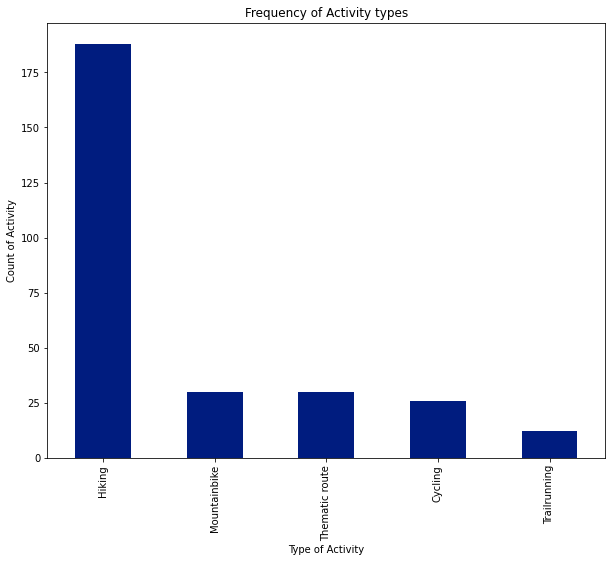

In [40]:
ax = analysis['sport'].value_counts().plot(kind='bar')
plt.title('Frequency of Activity types')
plt.xlabel('Type of Activity')
plt.ylabel('Count of Activity');

How does the picture look like by level of difficulty?

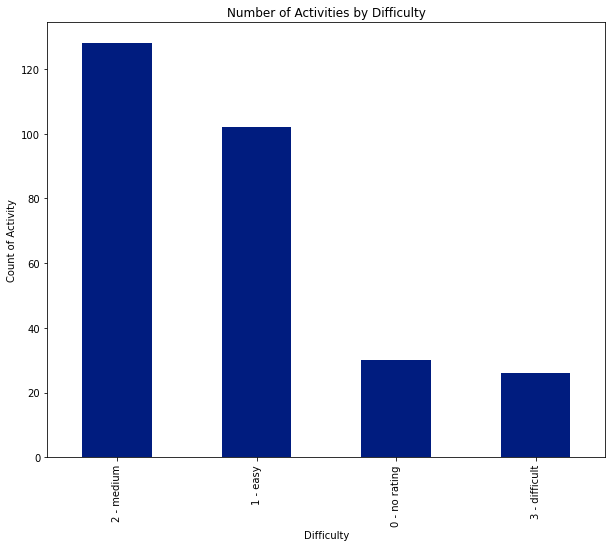

In [41]:
analysis['difficulty'].value_counts().plot(kind='bar')
plt.title('Number of Activities by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count of Activity');

## 3.4 Scatter Plot Visualization

The scatter plot paints an interesting picture of the trail data. First, the cycling trails are both the longest and the ones with most height difference out of the bunch. And second, it looks like all of the hiking trails fall between 2 and 20km (except for one). Perhaps this is because long distance hiking trails are considered to be "Pilgrimages"?

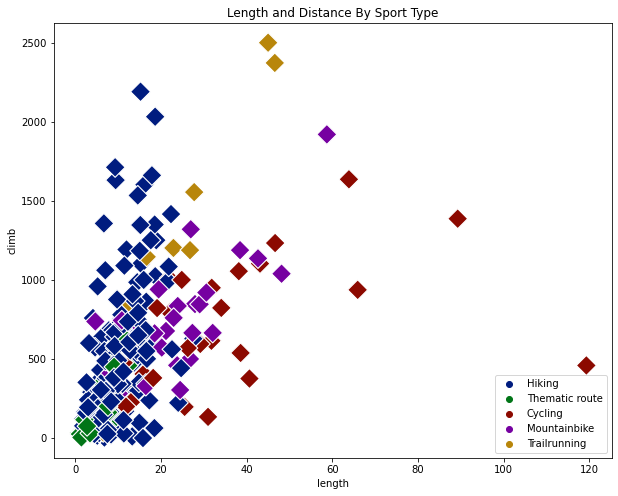

In [42]:
sns.scatterplot(    
    data=analysis,
    x="length", y="climb", hue='sport', 
    marker = "D", s=200, # set marker type and size
).set_title('Length and Distance By Sport Type')
plt.legend(loc='lower right'); # change default position of legend

In [43]:
# mean length for difficulty:
activities_df_br.groupby('difficulty').mean()

,ID,length,climb,min,max,technique,fitness
difficulty,,,,,,,
0 - no rating,452267.000000,12.640333,408.033333,841.966667,1237.500000,0.000000,0.000000
1 - easy,397930.828829,9.560450,251.378378,985.477477,1219.729730,1.369369,1.756757
2 - medium,432732.914286,15.402071,620.192857,1062.850000,1624.357143,2.464286,3.292857
3 - difficult,427644.054054,51.218108,2187.243243,835.324324,1879.864865,3.783784,5.351351


The average length increases with the difficulty level. However, there are non-rated trails that seem pretty long.

# 4 Analysis: Hiking Trails 

The primary interest of this analysis is hiking trail data. The following analysis will compare only hiking trails and drop the rest of the sport types.

In [44]:
hiking = activities_df_br[activities_df_br.sport == "Hiking"]
hiking.shape

(188, 11)

## 4.1 Scatter plot: Length and Vertical climb of each Activity By Difficulty

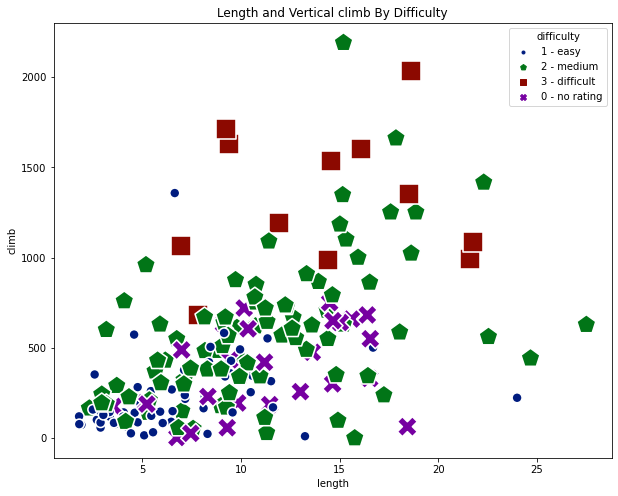

In [45]:
markers1 = {"1 - easy": ".", "2 - medium": "p",
           "3 - difficult":"s", "0 - no rating":"X"} #set the markers individually
sns.scatterplot(    
    data=hiking,
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    # rearrange order of the legend
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], 
    style='difficulty', markers = markers1, # set markers
    s = 400 # size of markers
).set_title('Length and Vertical climb By Difficulty');

Seems we have one "outlier" which is more than 200km long. Let's remove it to get a better view on the majority of the trails.

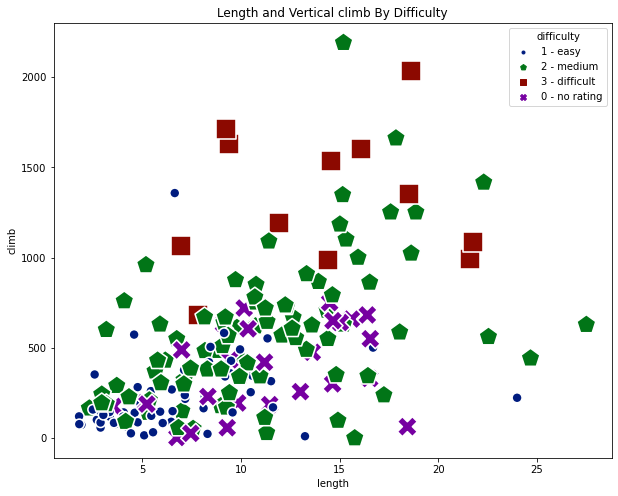

In [46]:
sns.scatterplot(    
    data=hiking[hiking.length < 200],
    x="length", y="climb", 
    hue='difficulty', # color by difficulty
    hue_order = ["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"], # rearrange order of the legend
    style='difficulty', markers = markers1, # set markers
    s = 400, # size of markers
).set_title('Length and Vertical climb By Difficulty');

The easier trails seem to be shorter in length and with lower elevation gain. Before we look at its correlation, let's compare the trail length vs. fitness score.

## 4.2 Line Plot: Comparison of average Trail Length vs. Fitness Score

The following dataframe uses the fitness scores and compares them to the length of each trail. A new columns is added for average length. Can we see a linear relationship? 

In [47]:
# calculating the count by Fitness level and the average length 
fitness_length_check = hiking.groupby('fitness') \
       .agg({'fitness':'count', 'length':'mean'}) \
       .rename(columns={'fitness':'count','length':'average_length'}) \
       .reset_index()
fitness_length_check

,fitness,count,average_length
0,0,28,11.155357
1,1,24,5.527083
2,2,41,8.039024
3,3,51,10.359412
4,4,30,12.293333
5,5,11,12.962727
6,6,3,16.493333


The routes with no fitness rating seems quite long. Probably related to the outlier previously identified.
For further analysis let's remove the trails without any difficulty rating and check if there is a visual clue.

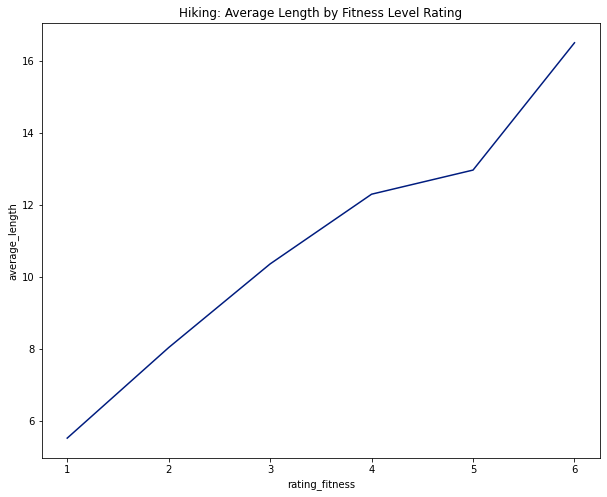

In [48]:
fitness_length = fitness_length_check[fitness_length_check['fitness'] != 0]
plt.plot(fitness_length["fitness"], fitness_length["average_length"])
plt.ylabel('average_length')
plt.xlabel("rating_fitness")
plt.title('Hiking: Average Length by Fitness Level Rating')
#sns.linewidth = 6
#check linestyle
plt.show()

There seems to be a linear relationship indeed between fitness score and length of the hike but let's have a closer look.

## 4.3 Boxplots: Difficulty vs. Elevation Gain and Length

The following boxplots show how the trail data is distributed by difficulty catagory compared to both elevation gain and length. It's pretty clear that the relationship between elevation gain and difficulty is more meaningful than the relationship between distance and difficulty. My legs agree! 

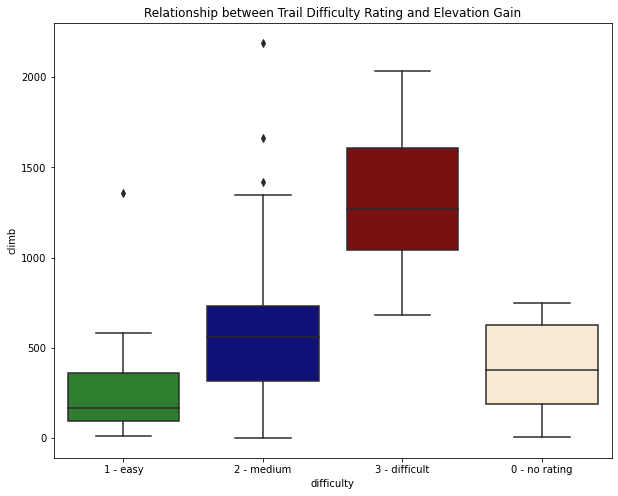

In [49]:
my_pal = {"1 - easy": "forestgreen", "2 - medium": "darkblue", "3 - difficult":"darkred", 
          "0 - no rating":"blanchedalmond"}
ax = sns.boxplot(x="difficulty", y="climb", data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Elevation Gain')\

# https://matplotlib.org/2.0.2/examples/color/named_colors.html

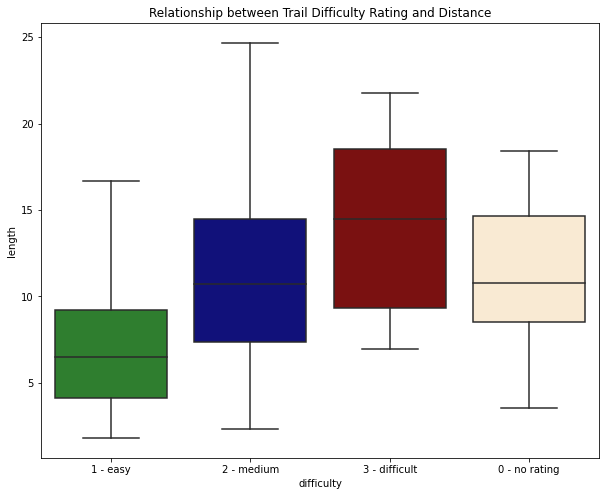

In [50]:
ax = sns.boxplot(x="difficulty", y="length",showfliers = False, data=hiking, 
                 order=["1 - easy", "2 - medium", "3 - difficult", "0 - no rating"],
                palette = my_pal) \
.set_title('Relationship between Trail Difficulty Rating and Distance')

## 4.4 Correlation Matrix
Let's see what the mathematical correlations are between the four parameters: climb, length, fitness score, technique score. For that, trails without any rating will be excluded.

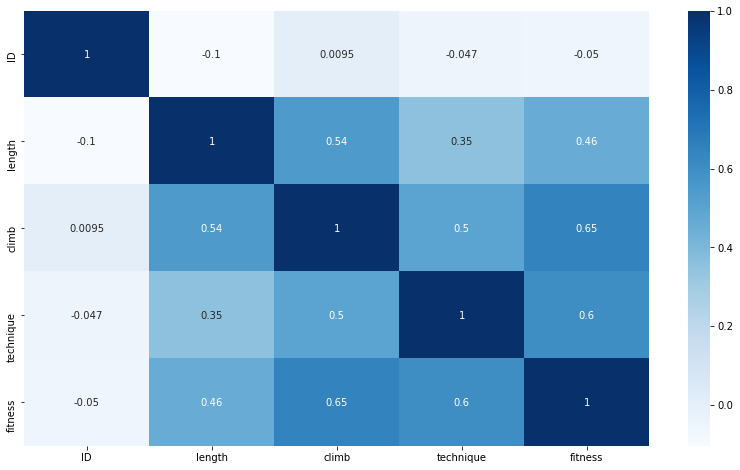

In [51]:
# remove numerical columns that are not needed and remove rows with no rating 
corr_matrix_df = hiking.drop(columns = ['min','max']).copy()
corr_matrix_df = corr_matrix_df[corr_matrix_df['difficulty'] != '0 - no rating']
# create a correlation matrix
corr_matrix = corr_matrix_df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues');

In [52]:
corr_matrix_df.head()

,ID,title,difficulty,sport,length,time,climb,technique,fitness
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,3,3
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,2,2
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,1,0
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,2,2
5,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,2,2


'Fitness' and 'Technique' have the highest correlation among all measures.
What about the correlation with the 'Difficulty Level'?
We therefore convert the 'easy', 'medium', 'difficult' in numeric values and build a correlation matrix.

In [53]:
# add numerical column indicating the difficulty level
corr_matrix_df['difficulty_level'] = corr_matrix_df['difficulty']
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '1 - easy', ['difficulty_level']] = 1
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '2 - medium', ['difficulty_level']] = 2
corr_matrix_df.loc[corr_matrix_df['difficulty'] == '3 - difficult', ['difficulty_level']] = 3

# the column 'difficulty_level' will return object type which we need to convert to integers.
corr_matrix_df['difficulty_level']= corr_matrix_df['difficulty_level'].astype(str).astype(int)
#or corr_matrix_df2 = pd.to_numeric(corr_matrix_df['difficulty_level']).astype(int)
corr_matrix_df2 = corr_matrix_df.copy()
corr_matrix_df2

,ID,title,difficulty,sport,length,time,climb,technique,fitness,difficulty_level
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",2 - medium,Hiking,10.69,03:45,624,3,3,2
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,1 - easy,Hiking,10.50,02:40,254,2,2,1
2,870922,Gehrihorn,1 - easy,Hiking,6.65,03:20,1357,1,0,1
3,733527,Einzigartig: der neue Gäggersteg,1 - easy,Hiking,13.36,04:00,510,2,2,1
5,509375,Merängge-Cher im Kemmribodenbad,1 - easy,Hiking,6.97,02:10,330,2,2,1
...,...,...,...,...,...,...,...,...,...,...
306,799947,Anspruchsvolle Gipfeltour,3 - difficult,Hiking,18.61,05:30,2032,6,6,3
307,62404,Five star walk,2 - medium,Hiking,15.77,08:00,0,2,4,2
308,456685,Rundweg Hüslimad,2 - medium,Hiking,3.18,01:09,189,2,3,2
311,190774,dw Schynige Platte,2 - medium,Hiking,5.95,02:07,305,3,1,2


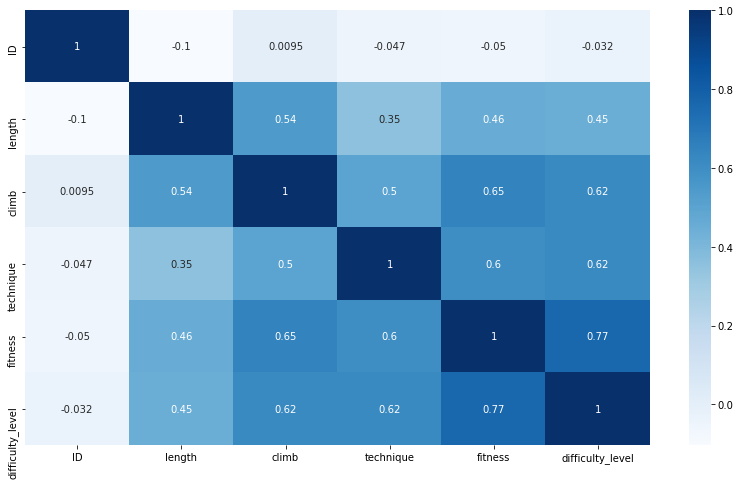

In [54]:
corr_matrix_level = corr_matrix_df2.corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr_matrix_level, annot = True, cmap = 'Blues');

As we can see, the highest correlation is between the fitness level and the difficulty level, followed by the technique and the difficulty level. This was not visible in the box plot graphs above.

# 5 Download Trail GPS Data

The next part of this notebook deals with parsing HTML tags again, however this time around we will be gathering the GPS data needed to create the snowfall alert in Milestone 3. The GPS data for each trail is actually a list of GPS points that comprises the length of the trail, from start to end. However, we will only be using the first GPS point in our algorithm, which is the trail head. 

The Bergfex website embeds their GPS data into downloadable files, which are meant to be uploaded to a GPS device for navigation purposes. As such, the following code will automatically download each GPS file into a folder. Importantly, a sleep timer is added to replicate how a human may download these files, if the sleep timer is not added, the website will become suspicious and prevent us from downloading more files. 

The type of GPS file that is being downloaded is a "GPX" or "GPS Exchange Format" file, which is a special type of XML file that can be used to describe waypoints. 

Finally, we crosscheck with Google Earth Web App, that our downloaded GPS data is exactly what we want.

## 5.1 Download Batches of GPX Files

This loop uses the activity ID's to navigate to each of the activity's pages. It then downloads the GPS file to the folder "gpx_files" and saves it as a filename "Unique_id.gpx". To prevent being blocked from the page, we download the data for only 5-10.

In [55]:
test_id = corr_matrix_df.iloc[:10,0]
test_id

0      48850
1      51212
2     870922
3     733527
5     509375
6      86143
7      99640
8     744919
9     316229
10    658326
Name: ID, dtype: int64

In [56]:
# create a small subset of data for testing
test_id = corr_matrix_df.iloc[:5,0]
for hike_id in test_id: 
    url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(hike_id)};fileType=kml"
    print(url_id)
    r = requests.get(url_id, allow_redirects=True)          # Send the request
    time.sleep(5)                                           # Include a timer to prevent blocking
    write_link = ('../gpx_files/'+ str(hike_id) + ".gpx")   # Create gpx file
    with open(write_link, 'wb') as f:
        f.write(r.content)                                  # Write data for each ID in each file

https://www.bergfex.com/downloads/gps/?type=&id=48850;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=51212;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=870922;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=733527;fileType=kml
https://www.bergfex.com/downloads/gps/?type=&id=509375;fileType=kml


Let's look at the content of one download. There are lots of data points of which the key data needs to be filtered out.

In [57]:
r.content

b'<?xml version="1.0" encoding="UTF-8"?>\n<gpx version="1.1" creator="GPSBabel - http://www.gpsbabel.org" xmlns="http://www.topografix.com/GPX/1/1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n  <metadata>\n    <time>2020-10-22T09:17:46.718Z</time>\n    <bounds minlat="46.793789000" minlon="7.934771000" maxlat="46.804588000" maxlon="7.965154000"/>\n  </metadata>\n  <trk>\n    <name>Mer\xc3\xa4ngge-Cher im Kemmribodenbad</name>\n    <trkseg>\n      <trkpt lat="46.802498000" lon="7.935082000">\n        <ele>990.000000</ele>\n        <time>2012-05-01T08:00:00Z</time>\n      </trkpt>\n      <trkpt lat="46.802334000" lon="7.936827000">\n        <ele>991.000000</ele>\n        <time>2012-05-01T08:00:33Z</time>\n      </trkpt>\n      <trkpt lat="46.802147000" lon="7.937363000">\n        <ele>993.000000</ele>\n        <time>2012-05-01T08:01:06Z</time>\n      </trkpt>\n      <trkpt lat="46.801743000" lon="7.938080000">\n        <ele>992.000000</ele>\n        <time>2012-05-01T08:01:39Z

##  5.2 Extract Coordinates from GPX files

Now that the GPX files have been downloaded to a local file, we can loop through them and extract the important information, which is the latitude and the longitude of the trail start.

In [58]:
list_of_trails_list = []
list_of_files = glob.glob('*gpx')                     # Create a list for each trail_id
for hike_id in test_id: 
    trail_gps_list = []
    gpx = gpxpy.parse(open('../gpx_files/'+str(hike_id)+'.gpx', 'r')) # Read content for each trail_id
    trail_gps_list.append(hike_id)
    for track in gpx.tracks: 
        trail_name = track.name                 # Track name
        trail_gps_list.append(trail_name)
        for segment in track.segments: 
            for point in segment.points: 
              lat = point.latitude              # Latitude
              trail_gps_list.append(lat)
              lon = point.longitude             # Longitude
              trail_gps_list.append(lon) 
              break
        list_of_trails_list.append(trail_gps_list)

print(list_of_trails_list)

[[48850, 'Zum Hinterburgseeli, dem Naturwunder auf der Axalp', 46.718933, 8.037732], [51212, 'Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen', 47.187939, 7.701375], [870922, 'Gehrihorn', 46.588749, 7.651042], [733527, 'Einzigartig: der neue Gäggersteg', 46.733341, 7.452745], [509375, 'Merängge-Cher im Kemmribodenbad', 46.802498, 7.935082]]


## 5.3  Create a Dataframe and save as CSV

Let's take a look at our data now that it has been extracted. It looks like everything is working as intended. Each trail has a unique ID and latitude and longitude. This data can now be saved to a CSV file which will be used for the snow alert in the next notebook. 

In [59]:
trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
trail_coords_df.to_csv('../data/trail_coords_df.csv', index=False) # save to CSV
coords_df = pd.read_csv('../data/trail_coords_df.csv')
coords_df

,trail_id,name,lat,lon
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",46.718933,8.037732
1,51212,Zu eiszeitlichen Riesen und zur Wohnstätte steinzeitlicher Menschen,47.187939,7.701375
2,870922,Gehrihorn,46.588749,7.651042
3,733527,Einzigartig: der neue Gäggersteg,46.733341,7.452745
4,509375,Merängge-Cher im Kemmribodenbad,46.802498,7.935082


## 5.4 Check GPS example

Let's test one ID (48850) with its coordinates (lat = 46.718933, lon = 8.037732) in Google Earth web app. It correctly displays the location. 

Bergfex GPS data:
- https://www.bergfex.com/downloads/gps/?type=&id=48850&fileType=kml

Google Earth web app:
- https://earth.google.com/web/search/46%2e718933+8%2e037732/@46.72096543,8.03751163,1503.22852736a,741.78182338d,35y,-80.11801825h,45.00028446t,0r/data=ClYaLBImGfGBHf8FXEdAIX0G1JtREyBAKhI0Ni43MTg5MzMgOC4wMzc3MzIYAiABIiYKJAkoo5mexUVHQBGyfRYeu0FHQBkErEmOIJsdQCGM9eFheUIdQA

In [60]:
example = coords_df[coords_df['trail_id'] == 48850]
example

,trail_id,name,lat,lon
0,48850,"Zum Hinterburgseeli, dem Naturwunder auf der Axalp",46.718933,8.037732


<IPython.core.display.Javascript object>


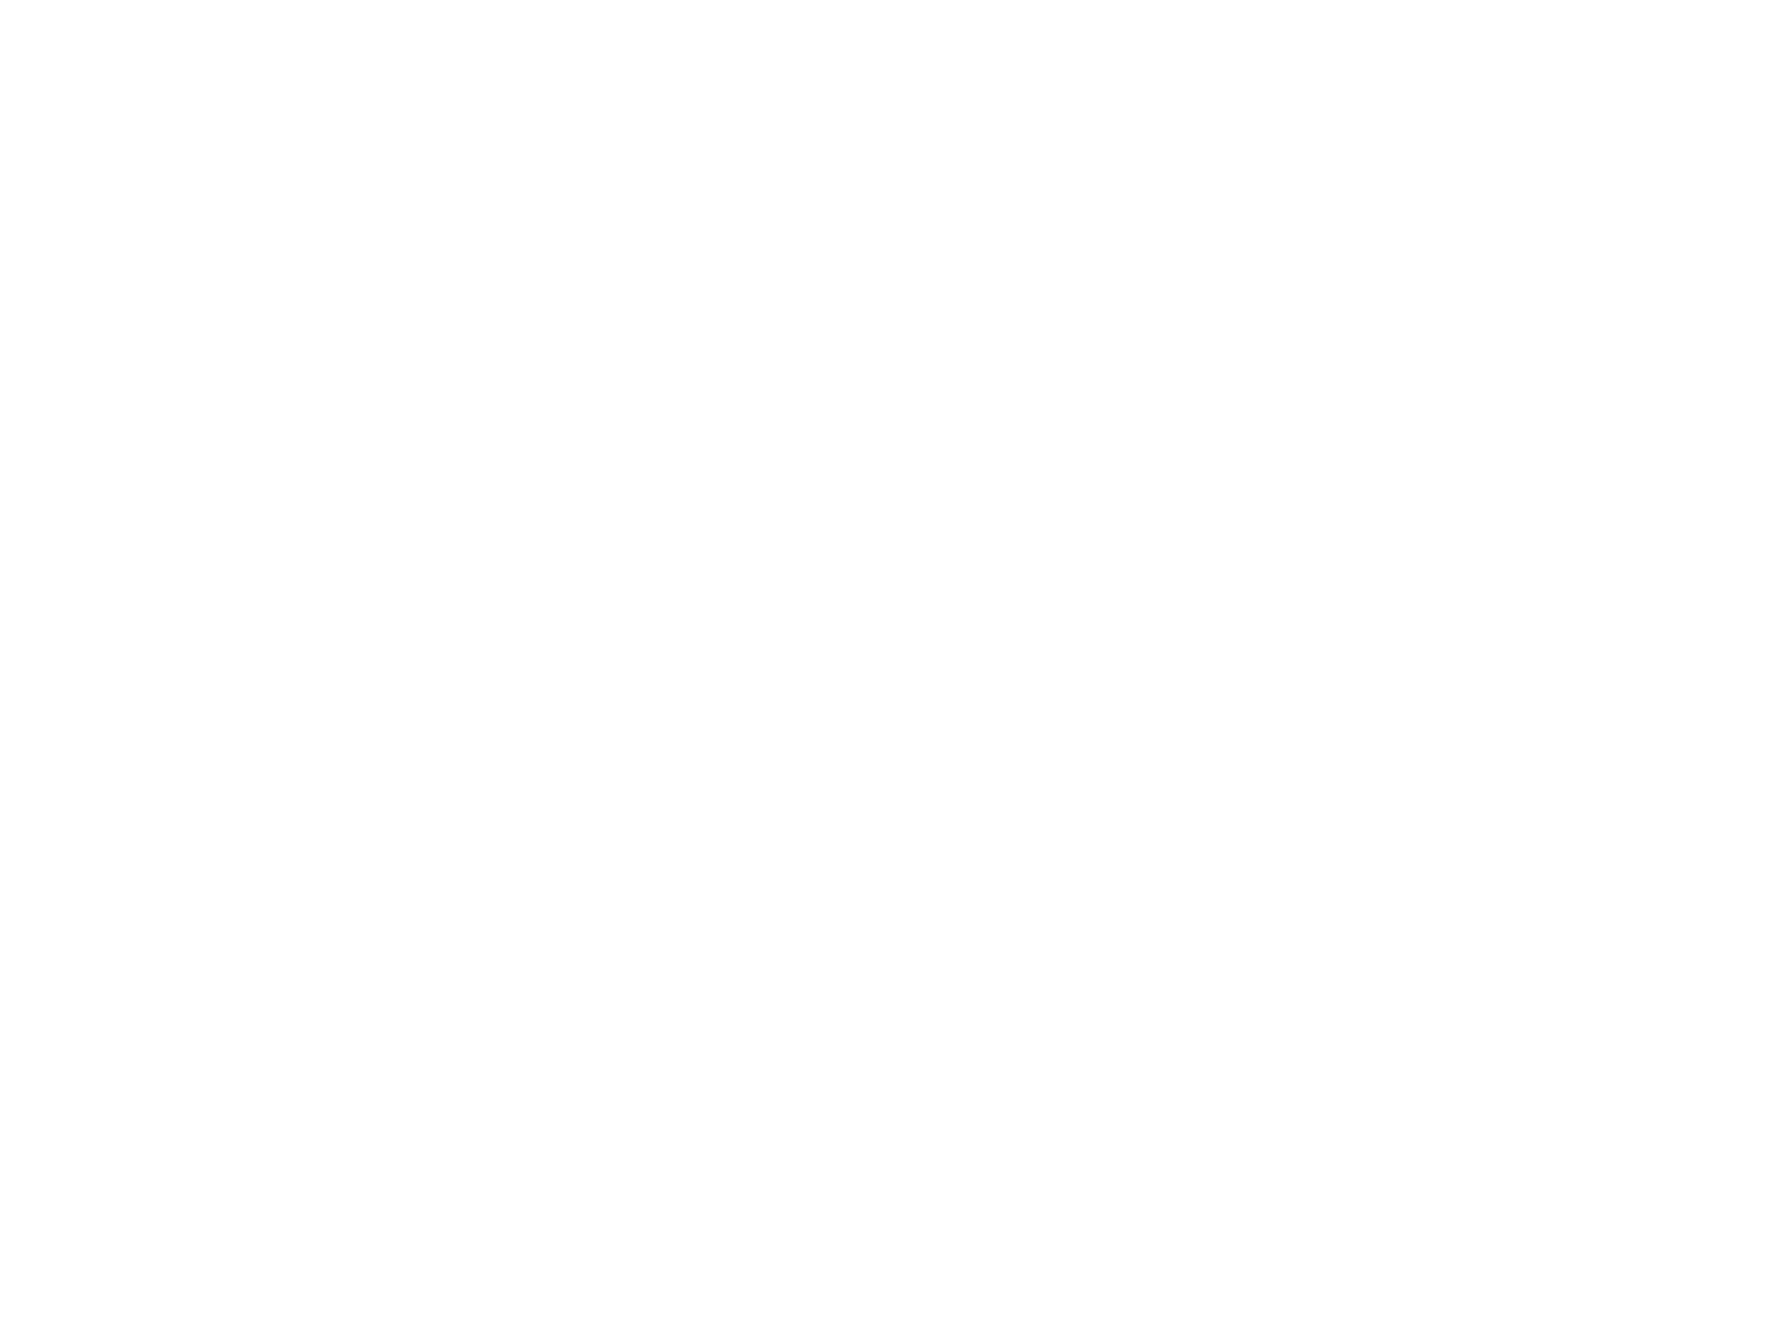

In [61]:
# needed to increase the display size of the png
%matplotlib notebook 
img = mpimg.imread('../examples/GoogleEarth.jpg')
plt.rcParams['figure.dpi'] = 140
imgplot = plt.imshow(img)

<IPython.core.display.Javascript object>


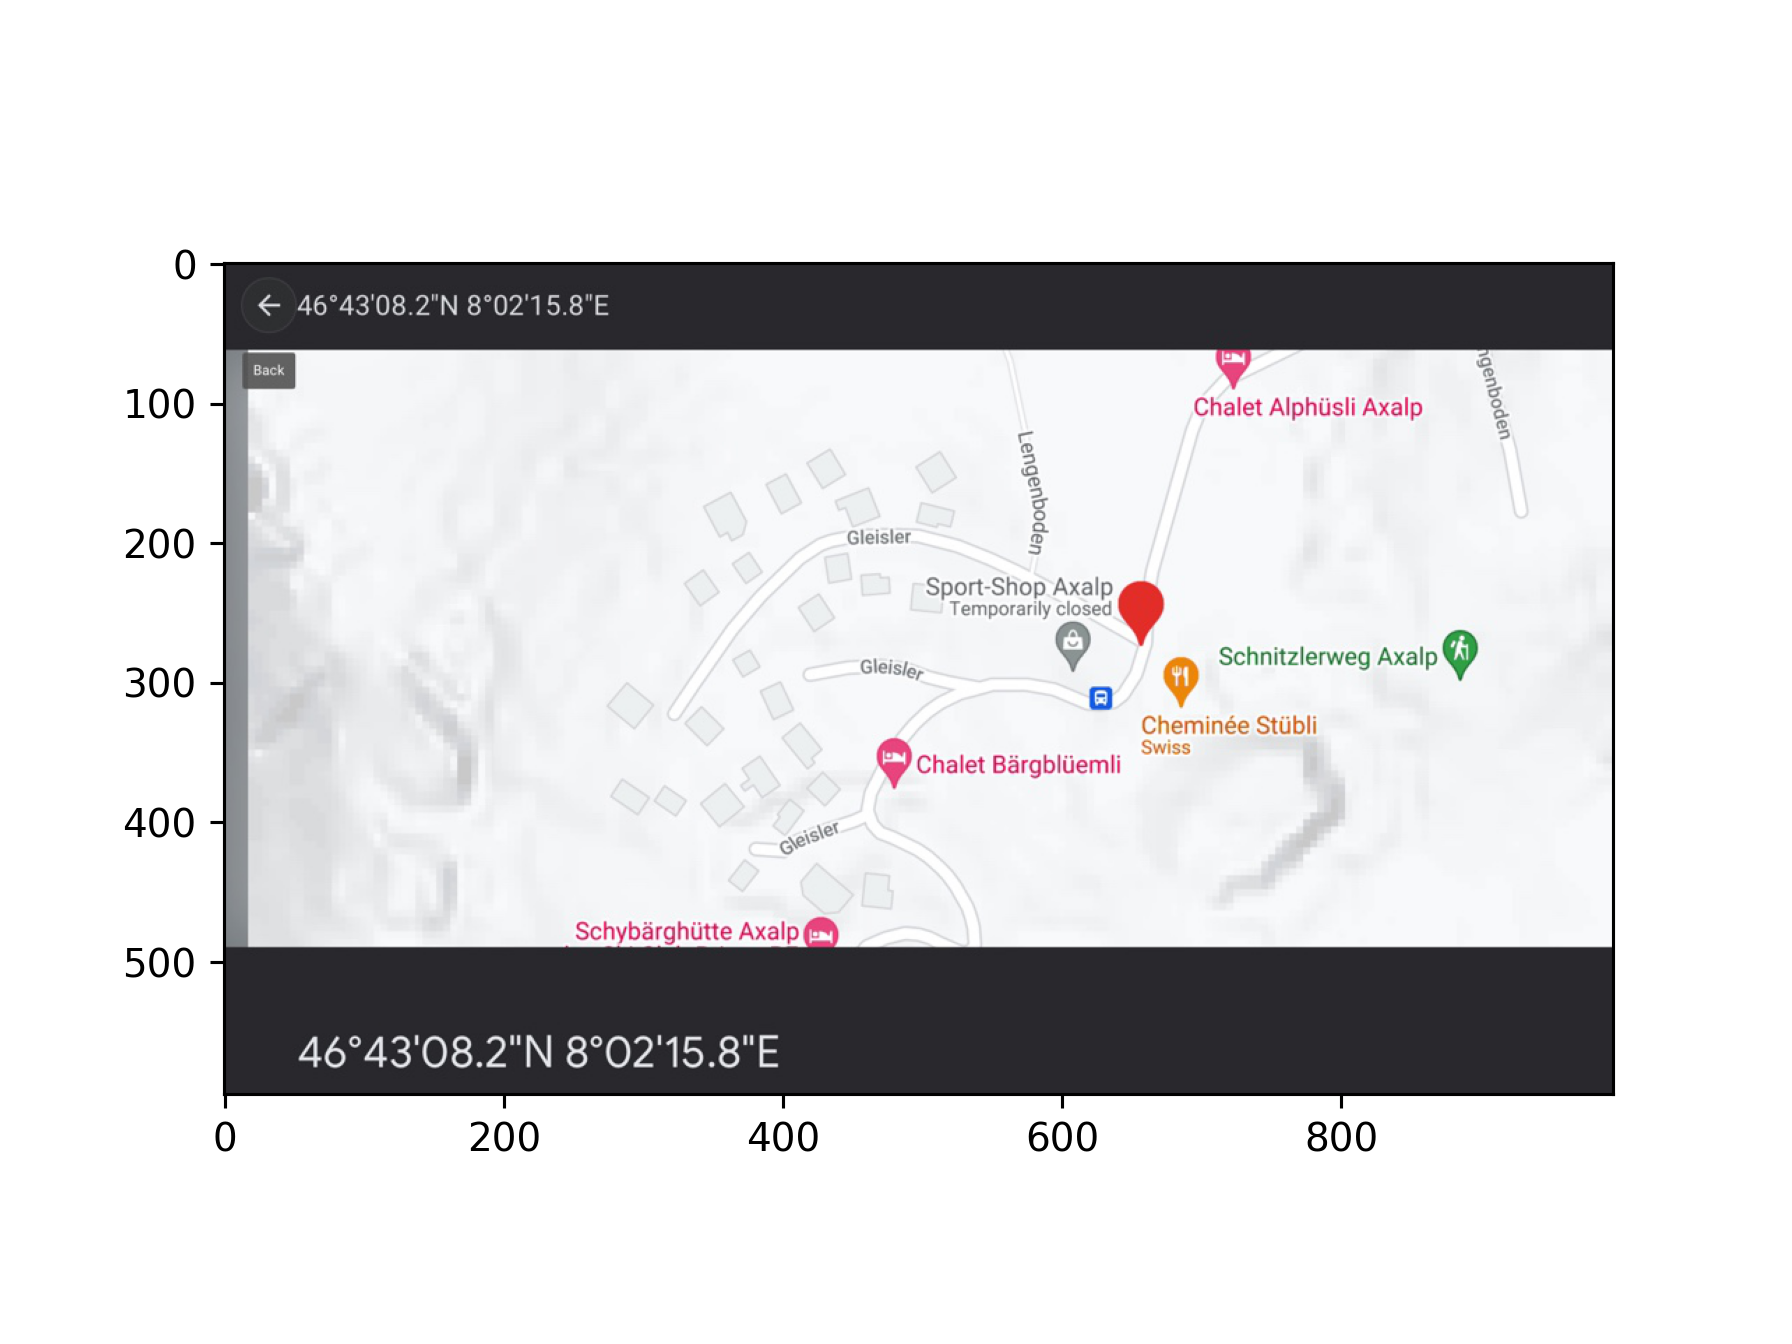

In [62]:
%matplotlib notebook 
img2 = mpimg.imread('../examples/GoogleEarth2.jpg')
plt.rcParams['figure.dpi'] = 140
imgplot2 = plt.imshow(img2)

## 5.5 Functions for GPS data

Now that we confirmed the GPS data, let's combine the code in functions. By adding tranches and a timer for their download, we make sure we will not be blocked by the website.

### Function to download the GPX data by regions and in tranches
We recommend a maximum tranch of 62 ID's with a timer of 2000 seconds in between. Executing this for all ID's can take quite some time, so we recommend to execute it by region.

In [63]:
def get_gpx_data(region, tranch_len, timer, save_as_csv = True):
    """
    This function downloads and saves GPX files in the gpx_files folder.

    Required arguments:
    - region: string,to save the results under region specific name, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'
    - tranch_len: int, to define the # of files that will be downloaded
    - timer: int, to set the # of seconds between each tranch
    
    Optional arguments:
    - save_as_csv: boolean, 'True' if intermediate CSV file should be created and saved.
    
    Returns:
    - trail_coords_df: dataframe, that contains the GPS information for each ID of each tranche.
    """
    start_time = time.time()
    
    for_gpx_df = pd.read_csv(f"../data/activities_{region}.csv") # import csv file for resp. region
    n_tranches = math.ceil(len(for_gpx_df.iloc[:,0])/ tranch_len) # calculate # of tranches
    
    tranch_df = pd.DataFrame()
    list_of_trails_list = []
    start_t = 0
    end_t = tranch_len
    
    for i in range(n_tranches): # subset all IDs into different tranches 
        tranch_df = for_gpx_df.iloc[start_t:end_t,0]
        start_t = start_t + tranch_len                # set new subset start
        end_t = start_t + tranch_len                  # set new subset end
        tranch_df = tranch_df.fillna(0).astype(int)   # format df
        ids_df = tranch_df.loc[(tranch_df != 0)]      # filter out non-valid IDs
        
        # download file for each ID of the subset
        for ids in ids_df: 
            url_id = f"https://www.bergfex.com/downloads/gps/?type=&id={str(ids)};fileType=kml"
            r = requests.get(url_id, allow_redirects=True)    # Send the request
            write_link = ('../gpx_files/'+ str(ids) + ".gpx") # Create gpx file
            with open(write_link, 'wb') as f:
                f.write(r.content)                            # Write data for each ID in each file
            # extract the trail_id, name of the hike, lat, lon from GPX files
            trail_gps_list = []
            gpx = gpxpy.parse(open('../gpx_files/'+str(ids)+'.gpx', 'r')) # Read content for each trail_id
            trail_gps_list.append(ids)                  # ID
            for track in gpx.tracks: 
                trail_name = track.name                 # Track name
                trail_gps_list.append(trail_name)
                for segment in track.segments: 
                    for point in segment.points: 
                      lat = point.latitude              # Latitude
                      trail_gps_list.append(lat)
                      lon = point.longitude             # Longitude
                      trail_gps_list.append(lon) 
                      break
                list_of_trails_list.append(trail_gps_list)
        time.sleep(timer) # timer to prevent being blocked
    
    trail_coords_df = pd.DataFrame(list_of_trails_list)        # save to DF
    trail_coords_df.columns=['trail_id', 'name', 'lat', 'lon'] # name the columns
    if save_as_csv == True:                                    # Option to save to csv
        trail_coords_df.to_csv(f'../data/trail_coords_df_{region}.csv', index=False)
    print("-- {0} seconds -- for {1} tranches".format(time.time() - start_time, n_tranches)) # time needed
    
    return trail_coords_df

### Function to add GPS data from downloaded GPX files to activity DF
Once we have all the GPX files for one region, we can add them to the activity df by merging the tables on the ID and removing duplicate columns.

In [64]:
def merge_activities_gpx(region):
    """
    This function merges the activities_df with the trail_coords_df.

    Required arguments:
    - region: string,to save the results under region specific name, one of the following: 
        'aargau', 'basel-region', 'bern-region', 'berneroberland', 'freiburg-region', 
           'genferseegebiet-waadtland', 'graubuenden', 'jura-drei-seen-land', 'luzern-vierwaldstaettersee',
          'ostschweiz', 'tessin', 'wallis', 'zuerich'

    Returns:
    - act_gpx: dataframe, that contains the activity data plus the GPS information for each ID 
    of each tranche.
    """
    act_df = pd.read_csv(f"../data/activities_{region}.csv")
    gpx_df = pd.read_csv(f"../data/trail_coords_df_{region}.csv")
    act_gpx = act_df.merge(gpx_df, how="left", left_on = 'ID', right_on = "trail_id")
    act_gpx = act_gpx.drop(columns=['name', 'trail_id'])
    act_gpx.to_csv(f"../data/activities_{region}_gpx.csv", index=False)
    return act_gpx

### Test GPS functions

Let's test if above functions work. For that we define the name of the region, set the tranch length to '2' and the timer to '2' seconds. We select 5 activities from the 'bern-region' DF.

In [65]:
# test get_gpx_data function (i.e. download)
test_reg_special = 'test_reg'
tranch_len = 2 # We recommend 62 ID's if you want to download lots of gpx files.
timer = 2 # We recommend 2000 seconds if you want to download lots of gpx files.

test_ids = activities_df_br.iloc[25:30,:]
test_ids.to_csv(f'../data/activities_{test_reg_special}.csv', index=False)
result_test = get_gpx_data(test_reg_special, tranch_len, timer, save_as_csv = True)
result_test

-- 7.13821005821228 seconds -- for 3 tranches


,trail_id,name,lat,lon
0,812686,Unterer Wasserfallrundwanderweg Engstligenalp,46.459003,7.566384
1,501843,Rund um Bönigen,46.688038,7.898305
2,224315,Walk to Lenk,46.493038,7.559211
3,131667,Gstaads 4 Finger Loop,46.475239,7.285006
4,49033,Kulturgeschichtliche Leckerbissen am Rugen,46.682198,7.851835


In [66]:
# test merge_activities_gpx function (i.e. download and merge with activities)
result_test2 = merge_activities_gpx(test_reg_special)
result_test2

,ID,title,difficulty,sport,length,time,climb,min,max,technique,fitness,lat,lon
0,812686,Unterer Wasserfallrundwanderweg,1 - easy,Hiking,1.92,00:35,73,1397,1509,2,2,46.459003,7.566384
1,501843,Rund um Bönigen,2 - medium,Running,9.86,01:33,98,564,661,1,3,46.688038,7.898305
2,224315,Walk to Lenk,2 - medium,Hiking,14.37,04:00,707,1070,1969,2,3,46.493038,7.559211
3,131667,Gstaads 4 Finger Loop,3 - difficult,Racing,59.09,03:30,976,1010,1384,2,5,46.475239,7.285006
4,49033,Kulturgeschichtliche Leckerbissen am Rugen,1 - easy,Hiking,7.56,02:30,400,561,785,2,2,46.682198,7.851835


# CONTINUE IN NOTEBOOK II